In [1]:
import os
import pandas as pd
HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [2]:
df = load_housing_data()

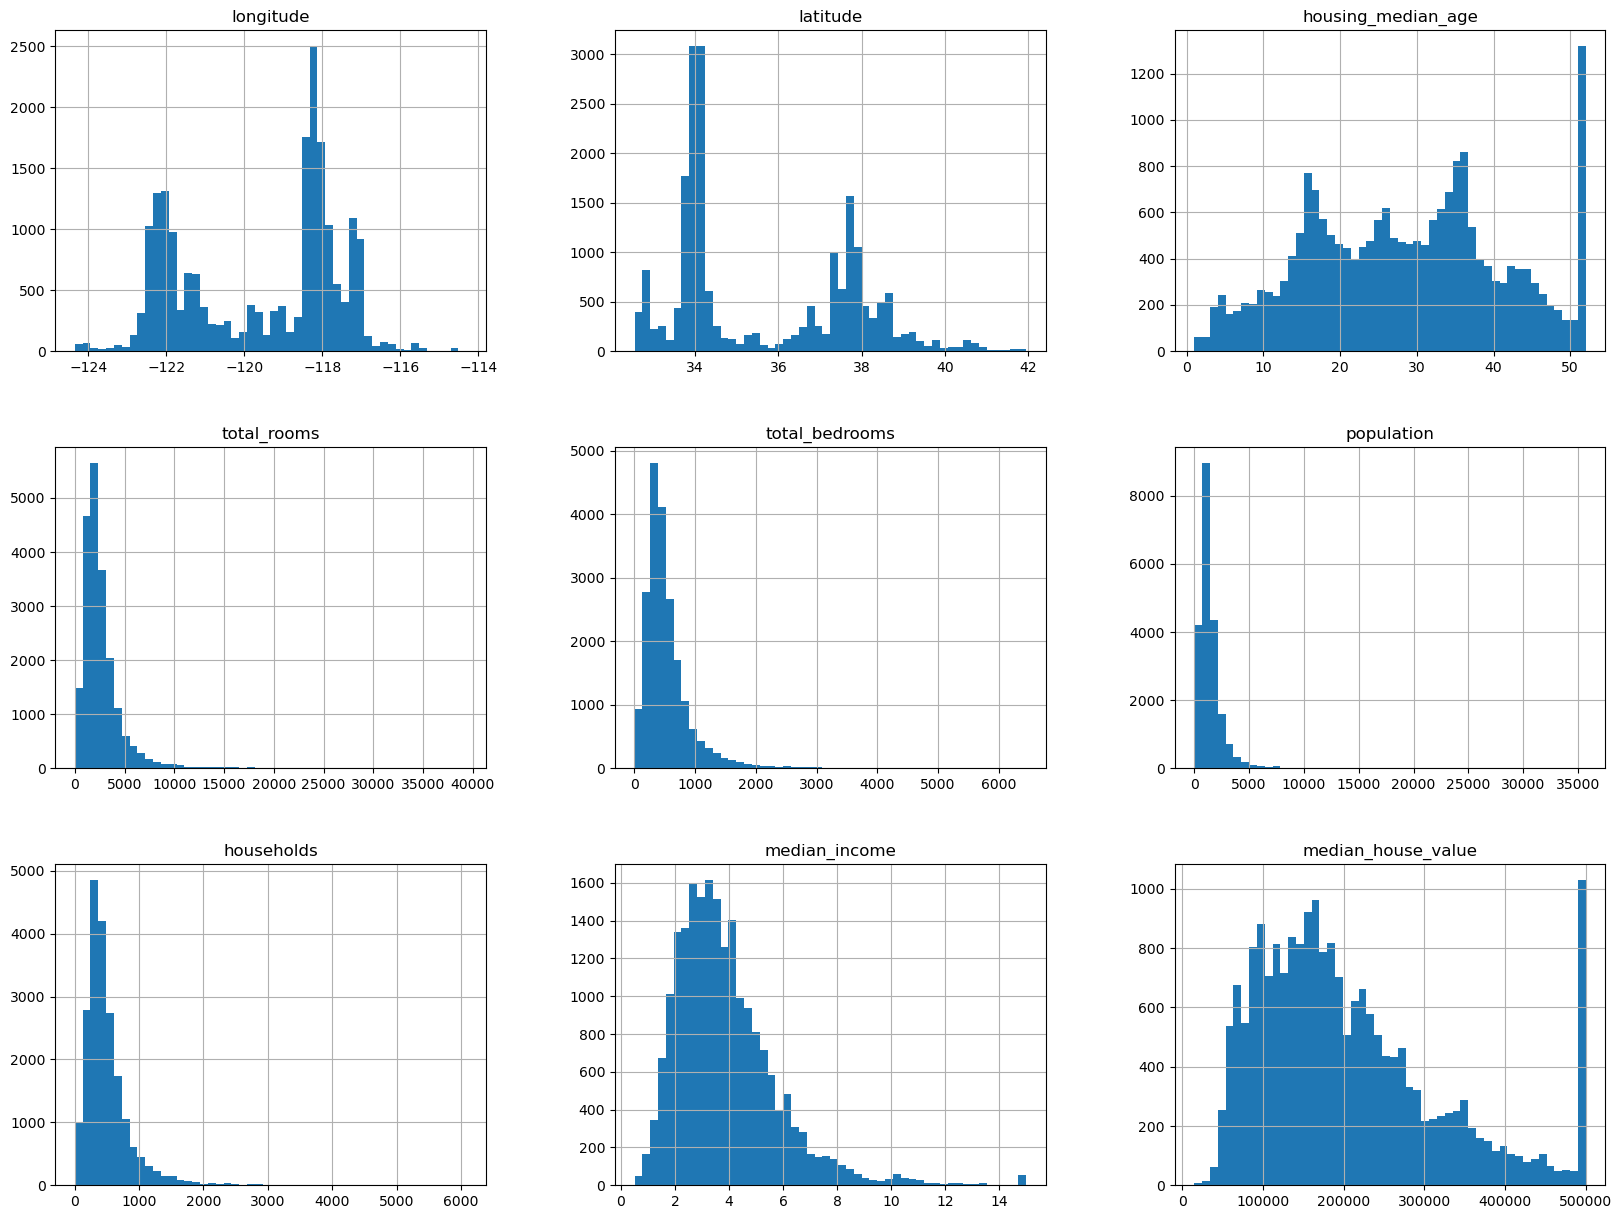

In [3]:
# Only in a Jupyter notebook: Use Jupyter's own backend
%matplotlib inline

import matplotlib.pyplot as plt
df.hist(bins = 50, figsize=(20, 15))
plt.show()

<AxesSubplot: >

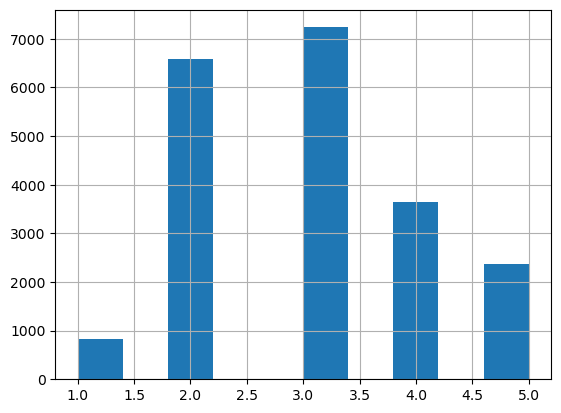

In [4]:
import numpy as np

df['income_cat'] = pd.cut(df['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                              labels=[1, 2, 3, 4, 5])

df['income_cat'].hist()

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [6]:
housing = strat_train_set.copy()

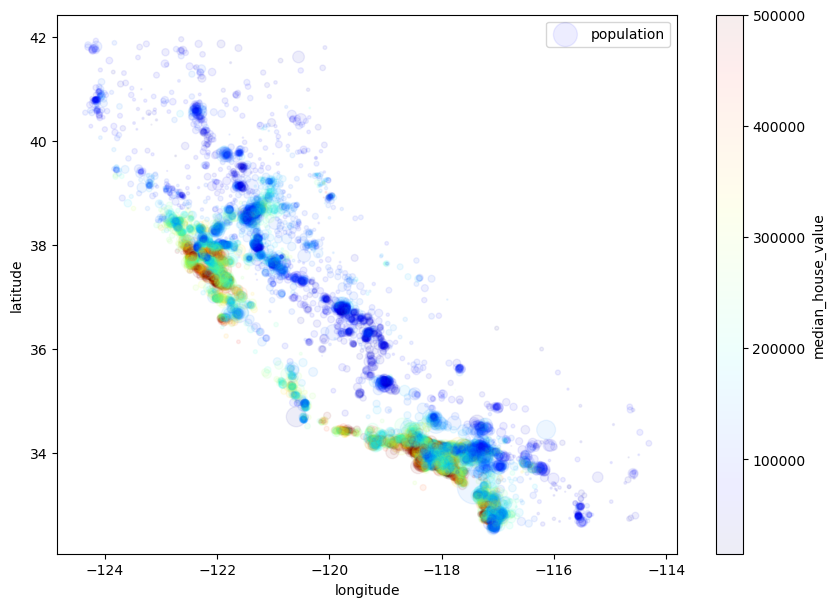

In [7]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.07,
            s=housing['population']/60, label='population', figsize=(10, 7),
            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()
plt.show()

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

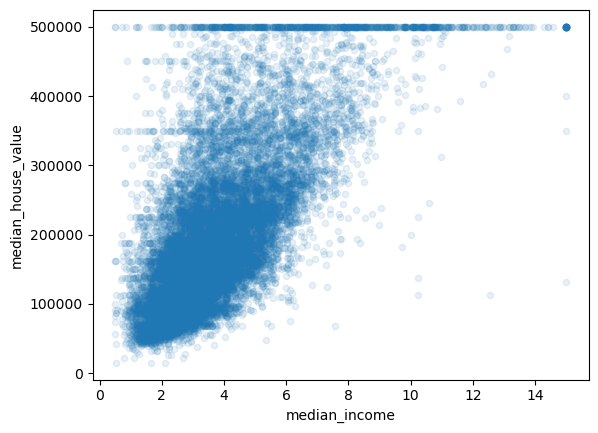

In [8]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [9]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

/tmp/ipykernel_11943/3704113406.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [10]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 2, 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 5, 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 2, 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., 3, 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., 3, 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 3, 5.477157360406092,
        3.1725888324873095]], dtype=object)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Pipelining using scikit-learn
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])

housing_num = housing.drop("ocean_proximity", axis=1) # Getting rid of ocean_proximity textual data

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

After finishing data preprocessing, let's move on to training

In [14]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)

SVR()

In [15]:
from sklearn.metrics import mean_squared_error

housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(svm_mse)

118451.153930123

Let's perform a grid search to find out the best parameters

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#C_range = np.logspace(-2, 10, 3)
#gamma_range = np.logspace(-9, 3, 3)
kernels = ['linear', 'rbf']

param_grid = dict(kernel=kernels)

svm_reg = SVR()

grid_reg = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

#grid_reg.fit(housing_prepared, housing_labels)

In [17]:
print(grid_reg.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
cvres = grid_reg.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_reg.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_reg.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

In [ ]:
from scipy import stats
confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))